In [1]:
from fastai.vision.all import *
import fastai
import timm
import torch
import albumentations as A
transform = A.load("/media/newhd/OPTRetina/DMAE/autoalbument-amd/outputs/2021-11-24/10-32-22/policy/latest.json")

In [2]:
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../trainValid.csv')

In [4]:
df

,Unnamed: 0,nombre_foto,grado de DMAE,binary,set
0,61504,anonymized_231059.jpg,normal,0,training
1,176989,anonymized_442122.jpg,normal,0,training
2,133399,anonymized_363034.jpg,normal,0,training
3,220150,anonymized_519072.jpg,normal,0,training
4,155853,anonymized_403989.jpg,normal,0,training
...,...,...,...,...,...
7797,224854,anonymized_528388.jpg,tardia,1,validation
7798,225492,anonymized_529721.jpg,intermedia,1,validation
7799,226322,anonymized_531350.jpg,precoz,1,validation
7800,227489,anonymized_533460.jpg,tardia,1,validation


In [5]:
def is_valid(path):
    name = path[1]
    return (df[df['nombre_foto']==name])['set'].values[0]=='validation'

# 224

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnetv2_224_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [7]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [8]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [9]:
dls = db.dataloaders(df.values,bs=16,num_workers=0)

In [10]:
learn = Learner(dls,timm.create_model('efficientnetv2_rw_s',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.261808,0.414200,0.619231,0.989474,0.241026,0.387629,0.880792,03:01


Better model found at epoch 0 with f1_score value: 0.38762886597938145.


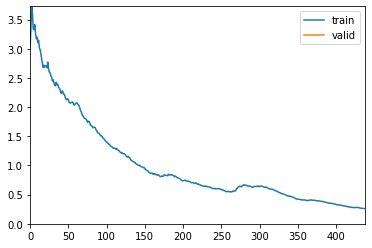

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.123213,0.087694,0.846154,0.932692,0.746154,0.829060,0.940220,03:01
1,0.116115,0.085833,0.858974,0.833333,0.897436,0.864198,0.935164,03:00
2,0.107415,0.172210,0.771795,0.692727,0.976923,0.810638,0.935700,03:01
3,0.097531,0.140303,0.776923,0.969565,0.571795,0.719355,0.941259,03:01
4,0.098135,0.112396,0.835897,0.948630,0.710256,0.812317,0.939135,03:02
5,0.096540,0.124659,0.825641,0.923333,0.710256,0.802899,0.923590,03:02
6,0.089027,0.104686,0.832051,0.891239,0.756410,0.818308,0.919300,03:01


Better model found at epoch 0 with f1_score value: 0.829059829059829.


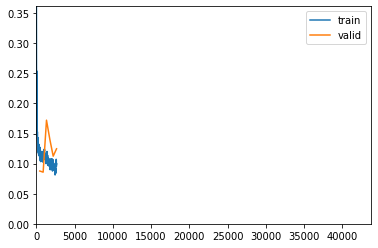

Better model found at epoch 1 with f1_score value: 0.8641975308641975.
No improvement since epoch 1: early stopping


In [11]:
learn.fine_tune(100,base_lr=3e-3)

In [12]:
dfTest = pd.read_csv('../testSample.csv')

In [13]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(384)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [15]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=64,num_workers=0)

In [16]:
learn.dls = dlsTest

In [17]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9514871794871795.


(#6) [0.07445822656154633,0.882564127445221,0.906318082788671,0.8533333333333334,0.8790279978869521,0.9514871794871795]

# 384

In [18]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnetv2_384_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [19]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [20]:
dls = db.dataloaders(df.values,bs=16,num_workers=0)

In [21]:
learn = Learner(dls,timm.create_model('efficientnetv2_rw_s',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [22]:
learn.load('efficientnetv2_224_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0002754228771664202)

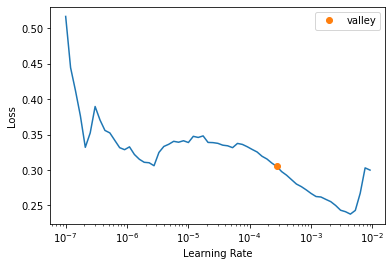

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.179913,0.171946,0.647436,0.681388,0.553846,0.611033,0.720684,03:11


Better model found at epoch 0 with f1_score value: 0.611032531824611.


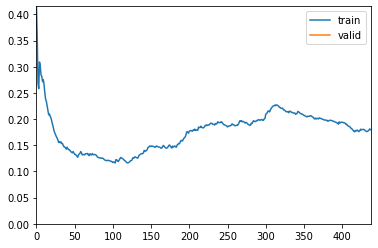

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.116414,0.094119,0.839744,0.934426,0.730769,0.820144,0.929882,03:11
1,0.109556,0.094644,0.823077,0.787671,0.884615,0.833333,0.923675,03:09
2,0.101499,0.088073,0.839744,0.807425,0.892308,0.847747,0.934471,03:10
3,0.105451,0.088951,0.861538,0.932515,0.779487,0.849162,0.935674,03:09
4,0.096653,0.101795,0.838462,0.958333,0.707692,0.814159,0.937561,03:10
5,0.101362,0.105418,0.819231,0.956044,0.669231,0.787330,0.935092,03:10
6,0.087292,0.094609,0.855128,0.928793,0.769231,0.841515,0.938649,03:10
7,0.094588,0.085863,0.864103,0.867876,0.858974,0.863402,0.935832,03:10
8,0.092478,0.138719,0.800000,0.736842,0.933333,0.823529,0.922078,03:11
9,0.083346,0.099100,0.817949,0.875758,0.741026,0.802778,0.930016,03:10


Better model found at epoch 0 with f1_score value: 0.8201438848920862.


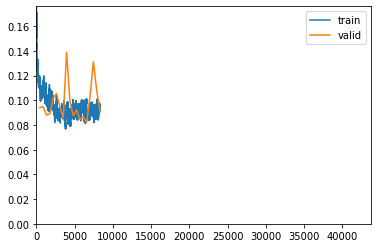

Better model found at epoch 1 with f1_score value: 0.8333333333333333.
Better model found at epoch 2 with f1_score value: 0.8477466504263094.
Better model found at epoch 3 with f1_score value: 0.8491620111731845.
Better model found at epoch 7 with f1_score value: 0.8634020618556699.
Better model found at epoch 10 with f1_score value: 0.8642857142857142.
No improvement since epoch 14: early stopping


In [24]:
learn.fine_tune(100,base_lr=3e-3)

In [25]:
dfTest = pd.read_csv('../testSample.csv')

In [26]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [27]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(512)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [28]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=32,num_workers=0)

In [29]:
learn.dls = dlsTest

In [30]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.9587324128862591.


(#6) [0.07850232720375061,0.882564127445221,0.8440959409594095,0.9384615384615385,0.88878096163186,0.9587324128862591]

# 512

In [31]:
import torch
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='efficientnetv2_512_b',monitor='f1_score'),
    #ReduceLROnPlateau(patience=2)
]

In [32]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_valid),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640),AlbumentationsTransform(transform[0])], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [33]:
dls = db.dataloaders(df.values,bs=8,num_workers=0)

In [34]:
learn = Learner(dls,timm.create_model('efficientnetv2_rw_s',num_classes=2,pretrained=True,drop_rate=0.5),
                metrics=[accuracy,Precision(),Recall(),F1Score(),RocAucBinary()],
                cbs=callbacks,
                loss_func= FocalLossFlat()).to_fp16()

In [35]:
learn.load('efficientnetv2_384_b')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(valley=0.0003311311302240938)

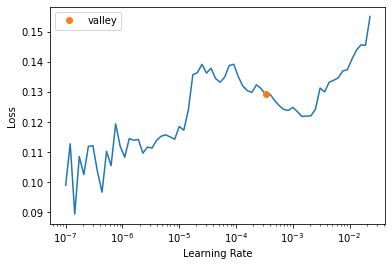

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.171190,0.211654,0.573077,0.743590,0.223077,0.343195,0.715687,05:07


Better model found at epoch 0 with f1_score value: 0.3431952662721894.


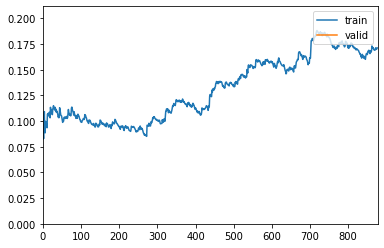

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.116882,0.098719,0.843590,0.903614,0.769231,0.831025,0.923307,05:07
1,0.102607,1.154637,0.841026,0.830846,0.856410,0.843434,0.903346,05:04
2,0.094264,0.092920,0.852564,0.903226,0.789744,0.842681,0.930417,04:46
3,0.085249,0.091714,0.856410,0.918675,0.782051,0.844875,0.935108,04:46
4,0.101134,0.118681,0.834615,0.832061,0.838462,0.835249,0.917863,04:47
5,0.079047,0.086292,0.858974,0.891061,0.817949,0.852941,0.938583,04:46
6,0.098399,0.090804,0.847436,0.807256,0.912821,0.856799,0.938179,04:46
7,0.093294,0.117644,0.861538,0.849010,0.879487,0.863980,0.935746,04:49
8,0.098144,0.088208,0.858974,0.909357,0.797436,0.849727,0.945352,04:46
9,0.084785,0.099717,0.833333,0.906250,0.743590,0.816901,0.932673,04:47


Better model found at epoch 0 with f1_score value: 0.8310249307479225.


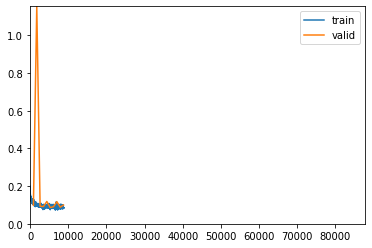

Better model found at epoch 1 with f1_score value: 0.8434343434343434.
Better model found at epoch 3 with f1_score value: 0.8448753462603878.
Better model found at epoch 5 with f1_score value: 0.8529411764705882.
Better model found at epoch 6 with f1_score value: 0.8567990373044524.
Better model found at epoch 7 with f1_score value: 0.8639798488664987.
No improvement since epoch 5: early stopping


In [37]:
learn.fine_tune(100,base_lr=3e-3)

In [38]:
dfTest = pd.read_csv('../testSample.csv')

In [39]:
def is_test(path):
    name = path[1]
    return (dfTest[dfTest['nombre_foto']==name])['set'].values[0]=='test'

In [40]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=FuncSplitter(is_test),
                 get_x = ColReader(1,pref="../amd/"),
                 get_y=ColReader(3),
                 item_tfms = [Resize(640)], # CropPad(200,200)
                 batch_tfms=[*aug_transforms(size=512, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=2.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                             Normalize.from_stats(*imagenet_stats)])

In [41]:
dlsTest = dbTest.dataloaders(dfTest.values,bs=8,num_workers=0)

In [42]:
learn.dls = dlsTest

In [43]:
learn.validate()

Better model found at epoch 0 with f1_score value: 0.958482577251808.


(#6) [0.06983664631843567,0.8979487419128418,0.8959183673469387,0.9005128205128206,0.8982097186700766,0.958482577251808]